In [28]:
import argparse, os, time
import pandas as pd
import geopandas as gpd
import polars as pl
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import matplotlib.patheffects as path_effects
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [29]:
year = 20
donors_csv = f"./output/donors_state{year}_pred_lastname_jew.csv"

In [30]:
donors = pd.read_csv(donors_csv)
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,jew
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,jew
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,jew
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,jew
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,jew
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [31]:
len(donors)

3588936

In [32]:
print(donors.sort_values(by="total_donated", ascending=False).head(10000)['total_donated'].sum()/donors["total_donated"].sum()*100)
donors.sort_values(by="total_donated", ascending=False).head(10)

52.08035503339197


,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
0,,ACTBLUE,actblue actblue,NaN,NaN,Y4000,,NaN,NaN,WASHINGTON,CA,1.261253e+09,25821,4.884603e+04,1000.0,actblue,not
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,jew
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,jew
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,F7000,M,INVESTMENTS,SELF-EMPLOYED,SARATOGA,WY,4.513356e+07,23,1.962328e+06,2800.0,mellon,not
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,jew
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,jew
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M7000,M,CEO,ULINE,LAKE FOREST,IL,3.536433e+07,319,1.108600e+05,2800.0,uihlein,not
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Citadel LLC,NaN,F2700,M,FOUNDER CEO,CITADEL LLC,CHICAGO,IL,3.366763e+07,188,1.790832e+05,2800.0,griffin,not
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,jew
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,Karla T Jurvetson MD,NaN,H1110,F,PHYSICIAN,SELF,LOS ALTOS,CA,3.308810e+07,914,3.620142e+04,2800.0,jurvetson,not


In [33]:
donors[donors["ethnic"] == "jew"].sort_values(by="total_donated", ascending=False).head(10)

,contrib_id,name,name_new,orgname,ultorg,realcode,gender,occupation,employer,city,state,total_donated,donation_count,avg_donation,med_donation,lastname,ethnic
1,U00000037041,"BLOOMBERG, MICHAEL R",michael r bloomberg,[Candidate Contribution],NaN,Z9000,M,FOUNDER,BLOOMBERG INC.,NEW YORK,NY,1.127731e+09,958,1.177172e+06,682.5,bloomberg,jew
2,U00000036521,"STEYER, TOM",tom steyer,[Candidate Contribution],NaN,Z9000,M,PRESIDENTIAL CANDIDATE,SELF-EMPLOYED,SAN FRANCISCO,CA,3.794782e+08,756,5.019553e+05,2800.0,steyer,jew
4,U0000000310A,"ADELSON, MIRIAM",miriam adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,H3200,F,PHYSICIAN,ADELSON CLINIC,LAS VEGAS,NV,4.499955e+07,124,3.628996e+05,2800.0,adelson,jew
5,U00000003101,"ADELSON, SHELDON G",sheldon g adelson,Las Vegas Sands,NaN,G6500,M,CEO,LAS VEGAS SANDS CORPORATION,LAS VEGAS,NV,4.484795e+07,119,3.768735e+05,2800.0,adelson,jew
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,F2600,M,CHAIRMAN,BLACKSTONE,NEW YORK,NY,3.345400e+07,226,1.480265e+05,2800.0,schwarzman,jew
10,U00000045921,"MOSKOVITZ, DUSTIN AARON",dustin aaron moskovitz,Asana,NaN,C5120,M,CO-FOUNDER,ASANA,SAN FRANCISCO,CA,2.930419e+07,112,2.616446e+05,10000.0,moskovitz,jew
11,U00000003151,"SIMONS, JAMES",james simons,Euclidean Capital,NaN,Z9500,M,PHILANTHROPIST,EUCLIDEAN CAPITAL,NEW YORK,NY,2.197960e+07,241,9.120166e+04,2800.0,simons,jew
12,U0000004604,"SUSSMAN, S DONALD",s donald sussman,Paloma Partners,NaN,F2700,M,INVESTMENT ADVISOR,PALOMA PARTNERS ADVISORS LP,FT LAUDERDALE,FL,2.181760e+07,465,4.691957e+04,2800.0,sussman,jew
13,U00000042451,"YASS, JEFF",jeff yass,Susquehanna International Group,NaN,F2100,M,MANAGING DIRECTOR,SIG,BALA CYNWYD,PA,1.606140e+07,94,1.708660e+05,2800.0,yass,jew
15,U0000004682,"SIMON, DEBORAH",deborah simon,Simon Youth Foundation,NaN,X4100,F,NOT EMPLOYED,NOT EMPLOYED,CARMEL,IN,1.542136e+07,1015,1.519346e+04,675.0,simon,jew


In [34]:
print(donors["total_donated"].sum())
print(donors[donors["ethnic"] == "jew"]["total_donated"].sum())
print((donors[donors["ethnic"] == "jew"]["total_donated"].sum()/donors["total_donated"].sum())*100, "% of donated amount is from diaspora")

12004197961.0
3205648486.0
26.70439538247132 % of donated amount is from diaspora


In [35]:
print(len(donors))
print(len(donors[donors["ethnic"] == "jew"]))
print((len(donors[donors["ethnic"] == "jew"])/len(donors))*100, "% of donors are from diaspora")

3588936
417270
11.626565645082554 % of donors are from diaspora


In [36]:
print(donors["donation_count"].median())
print(donors[donors["ethnic"] == "jew"]["donation_count"].median())

3.0
3.0


In [37]:
print(donors["total_donated"].median())
print(donors[donors["ethnic"] == "jew"]["total_donated"].median())

432.0
500.0


In [38]:
print(donors["total_donated"].mean())
print(donors[donors["ethnic"] == "jew"]["total_donated"].mean())

3344.7790545721627
7682.432204567785


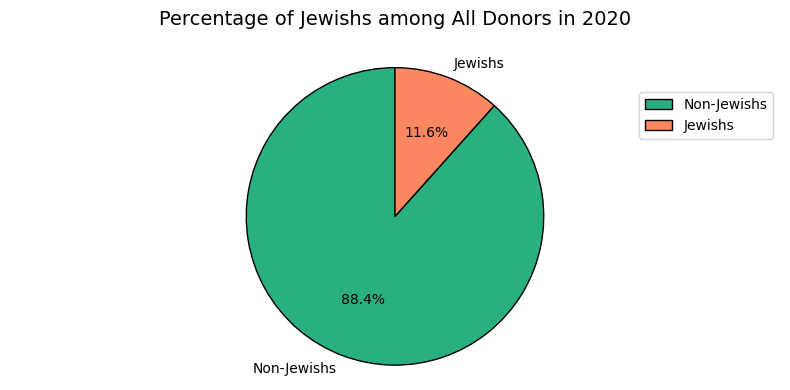

In [39]:
jewish_counts = donors['ethnic'].value_counts()

plt.figure(figsize=(8, 4))
plt.pie(jewish_counts, 
        labels=['Non-Jewishs', 'Jewishs'], 
        colors=['#2ab07f', '#fb8761'], 
        autopct='%1.1f%%', 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        textprops={'fontsize': 10})

plt.title(f'Percentage of Jewishs among All Donors in 20{year}', pad=20, fontsize=14)
plt.axis('equal')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
plt.tight_layout()
plt.show()

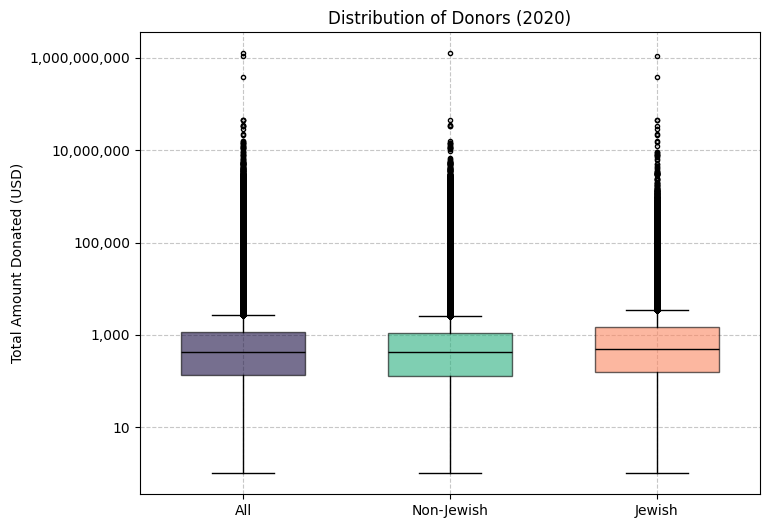

In [40]:
amounts_all = donors['total_donated']
amounts_non_jewish = donors[donors['ethnic'] == "not"]['total_donated']
amounts_jewish = donors[donors['ethnic'] == "jew"]['total_donated']

plt.figure(figsize=(8, 6))
plot = plt.boxplot([amounts_all, amounts_non_jewish, amounts_jewish], 
                   tick_labels=["All", "Non-Jewish", "Jewish"], 
                   patch_artist=True, 
                   widths=0.6, 
                   medianprops={"color": "black", "linewidth": 1}, 
                   flierprops={"marker": "o", "markersize": 3})

colors = ["#1b1044", "#2ab07f", "#fb8761"]
for patch, color in zip(plot["boxes"], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

plt.title(f"Distribution of Donors (20{year})")
plt.ylabel("Total Amount Donated (USD)")
plt.yscale("log")
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

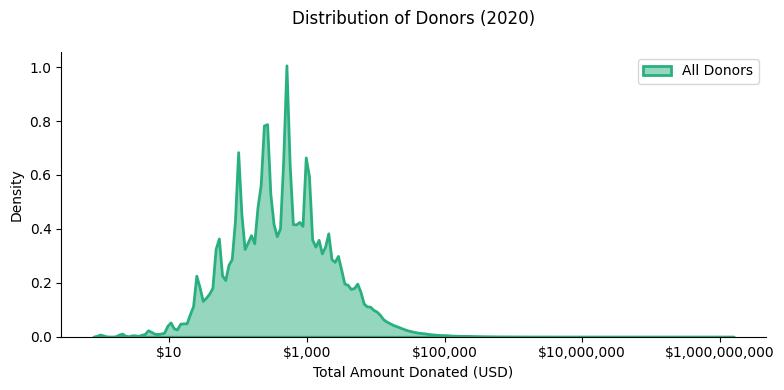

In [41]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
]['total_donated'],
            label='All Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

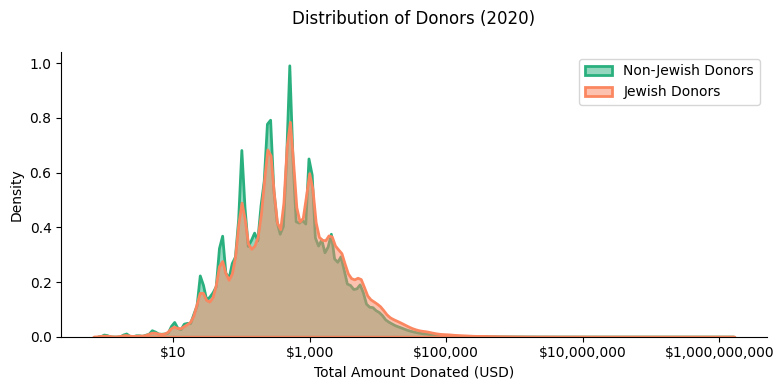

In [42]:
plt.figure(figsize=(8, 4))

sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "not"]['total_donated'],
            label='Non-Jewish Donors',
            color='#2ab07f',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)
sns.kdeplot(data=donors[
    (donors['total_donated'].notna()) & 
    (donors['total_donated'] > 0)
][donors['ethnic'] == "jew"]['total_donated'],
            label='Jewish Donors',
            color='#fb8761',
            fill=True,
            alpha=0.5,
            linewidth=2,
            log_scale=True)

plt.title(f"Distribution of Donors (20{year})", pad=20)
plt.xlabel("Total Amount Donated (USD)")
plt.ylabel("Density")
plt.xscale('log')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))
plt.legend()
sns.despine()
plt.tight_layout()
plt.show()

In [43]:
state_stats = (
    donors.groupby("state")
    .agg(
        avg_amount=("total_donated", "mean"),
        med_amount=("total_donated", "median"),
        total_donations=("total_donated", "sum"),
        donor_count=("total_donated", "count"),
        avg_amount_jewish=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "jew"].mean()),
        med_amount_jewish=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "jew"].median()),
        total_donations_jewish=("total_donated", lambda x: x[donors.loc[x.index, "ethnic"] == "jew"].sum()),
        donor_count_jewish=("total_donated", lambda x: (donors.loc[x.index, "ethnic"] == "jew").count())
    )
    .sort_values("total_donations", ascending=False)
    .reset_index()
)
state_stats.head(10)

,state,avg_amount,med_amount,total_donations,donor_count,avg_amount_jewish,med_amount_jewish,total_donations_jewish,donor_count_jewish
0,CA,6190.573397,471.0,3.367424e+09,543960,10204.532667,500.0,7.264505e+08,543960
1,NY,8464.925874,497.0,2.086477e+09,246485,31746.731876,525.0,1.435873e+09,246485
2,TX,2907.870775,500.0,7.675790e+08,263966,3178.003535,500.0,7.011947e+07,263966
3,FL,3149.138199,410.0,7.071264e+08,224546,5190.977783,500.0,1.401875e+08,224546
4,IL,3051.937811,425.0,3.857802e+08,126405,3593.683702,500.0,5.948984e+07,126405
5,MA,3138.322948,500.0,3.450963e+08,109962,5373.344007,500.0,8.306652e+07,109962
6,VA,2208.131878,500.0,2.599457e+08,117722,2441.409735,500.0,2.894047e+07,117722
7,WA,2017.417650,390.0,2.502486e+08,124044,2857.518774,450.0,3.645337e+07,124044
8,PA,1834.059197,401.0,2.457529e+08,133994,3108.313250,464.5,5.437683e+07,133994
9,GA,2477.590946,500.0,2.429476e+08,98058,3906.720985,500.0,3.332433e+07,98058


In [44]:
# Load U.S. states geometry (Natural Earth dataset)
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces.zip"
gdf = gpd.read_file(url)

exclude_codes = ["US-AK", "US-HI", "US-PR", "US-GU", "US-VI", "US-AS", "US-MP"]
gdf = gdf[(gdf["iso_a2"] == "US") & (~gdf["iso_3166_2"].isin(exclude_codes))][["iso_3166_2", "name", "geometry"]]
gdf["state"] = gdf["iso_3166_2"].str.replace("US-", "")
gdf_merged = gdf.merge(state_stats, on="state", how="left")

In [45]:
population = pd.read_csv("./data/aapi_population.csv", sep="\t")
population.head(10)

,Year,Name,Code,Indian Pop,Census Pop,Share
0,2020,Alabama,AL,14673,5033094,0.291530
1,2020,Alaska,AK,0,733017,0.000000
2,2020,Arizona,AZ,62246,7187135,0.866075
3,2020,Arkansas,AR,12461,3014546,0.413362
4,2020,California,CA,856180,39521958,2.166340
5,2020,Colorado,CO,33486,5787129,0.578629
6,2020,Connecticut,CT,61888,3579918,1.728755
7,2020,Delaware,DE,16076,991928,1.620682
8,2020,District of Columbia,DC,176769,670917,26.347372
9,2020,Florida,FL,181805,21592035,0.842000


In [46]:
gdf_merged = gdf_merged.merge(population, left_on="state", right_on="Code", how="left")

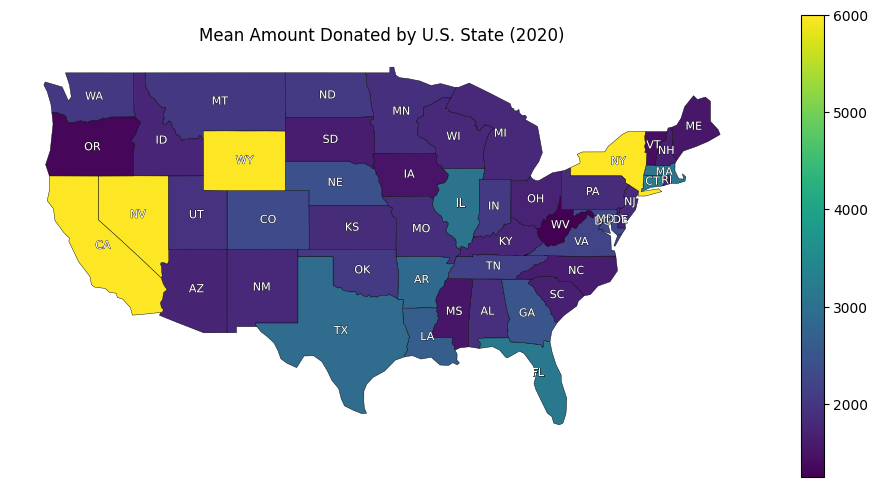

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

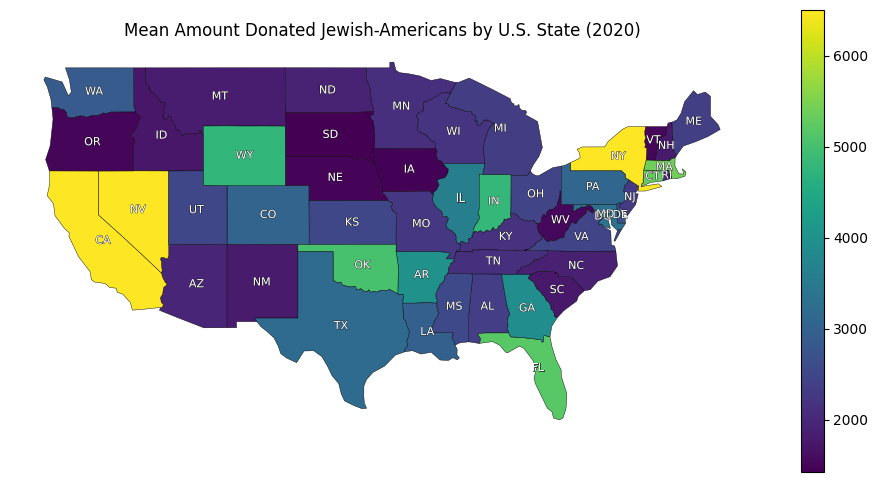

In [48]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="avg_amount_jewish",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=6500
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Mean Amount Donated Jewish-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

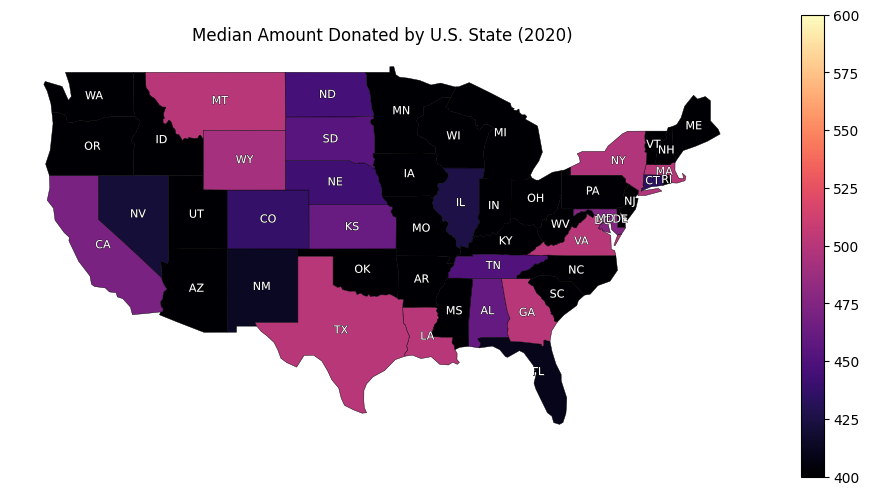

In [49]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=400,
    vmax=600
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

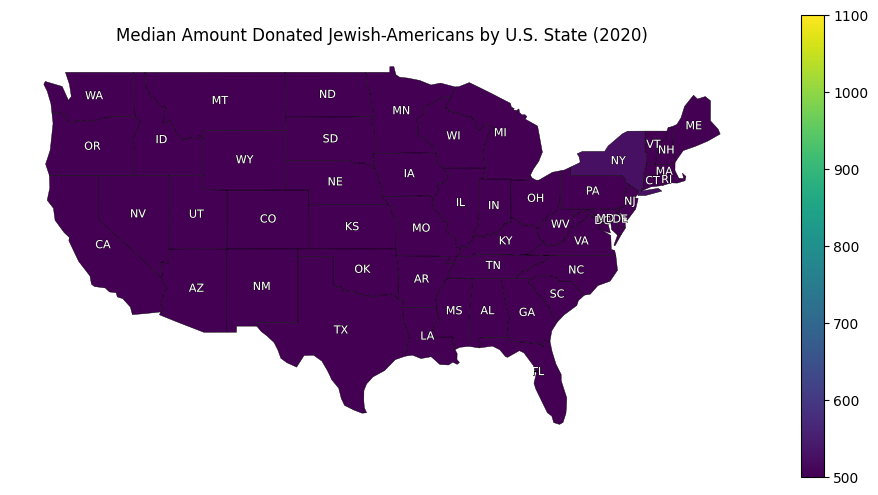

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="med_amount_jewish",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=500,
    vmax=1100
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Median Amount Donated Jewish-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

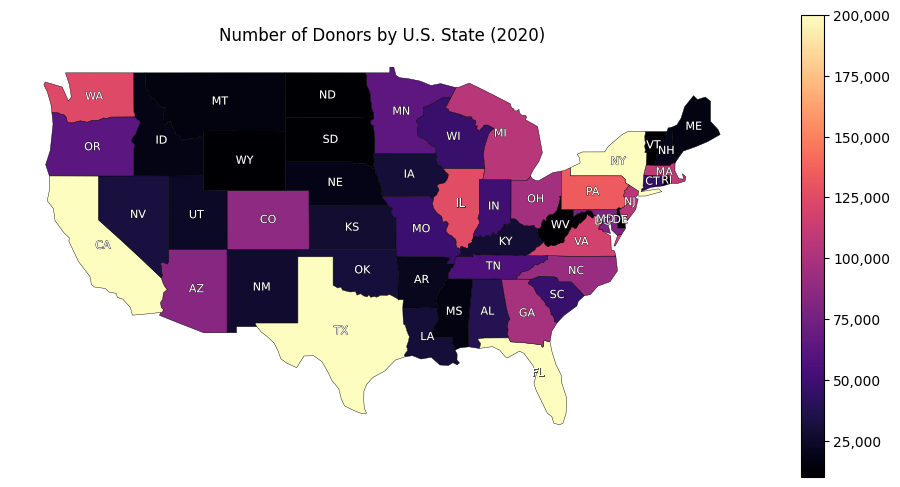

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="donor_count",
    cmap="magma",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=10000,
    vmax=200000
)

cbar = fig.axes[-1]
cbar.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:,.0f}"))

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Donors by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

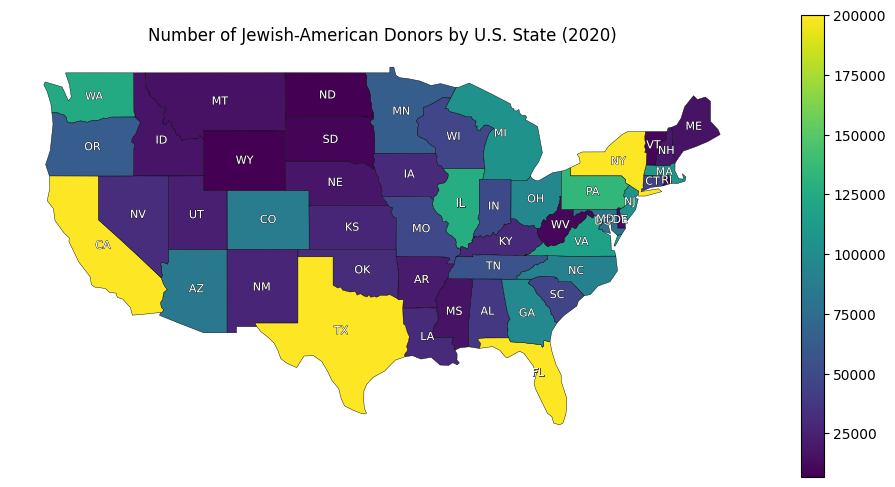

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="donor_count_jewish",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=200000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Number of Jewish-American Donors by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

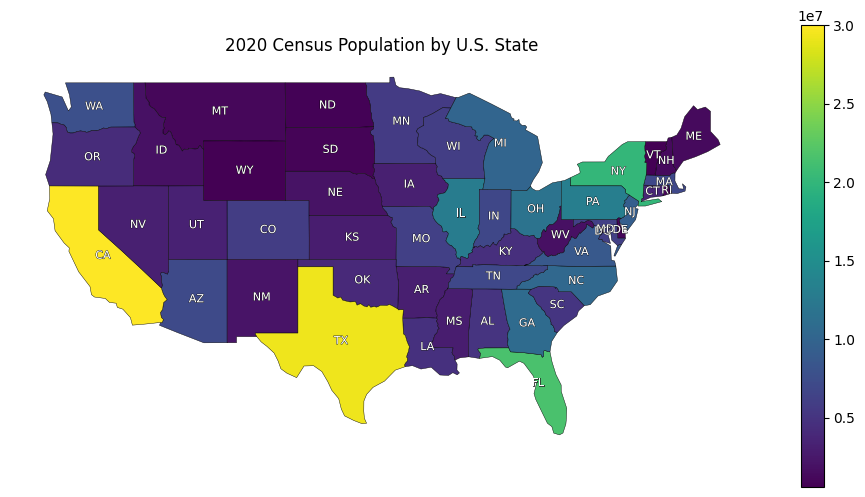

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Census Pop",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=30000000,
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"2020 Census Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

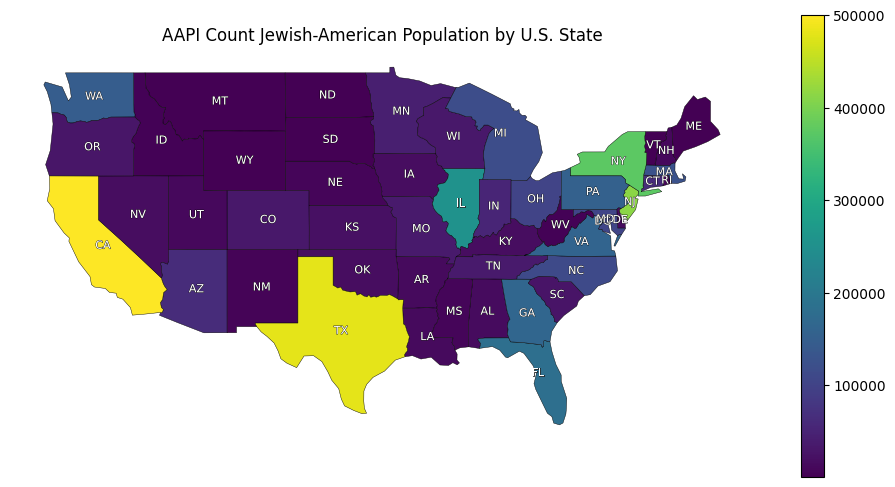

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Indian Pop",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=500000
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count Jewish-American Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

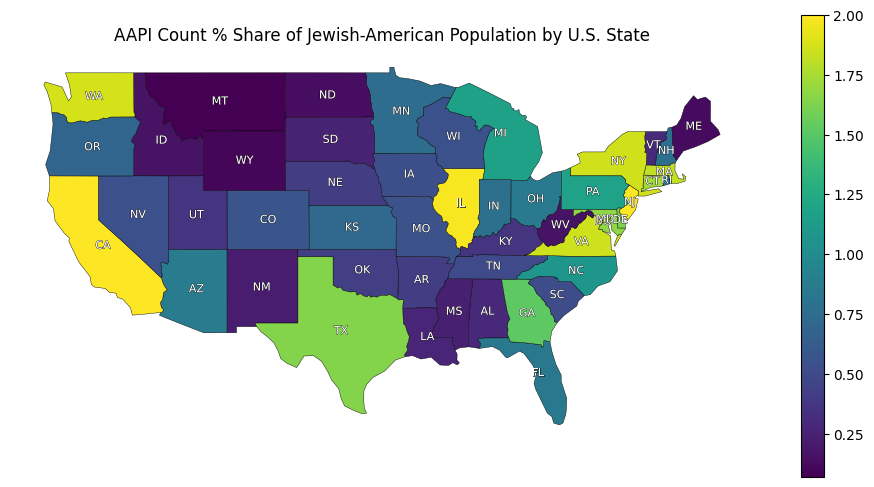

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="Share",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=2
)

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"AAPI Count % Share of Jewish-American Population by U.S. State")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

In [56]:
gdf_merged["don_per_capita"] = gdf_merged["donor_count"] / gdf_merged["Census Pop"] * 100
gdf_merged["don_per_capita_jewish"] = gdf_merged["donor_count_jewish"] / gdf_merged["Indian Pop"] * 100
gdf_merged["don_per_capita_diff"] = gdf_merged["don_per_capita_jewish"] - gdf_merged["don_per_capita"]
gdf_merged["dollars_per_capita"] = gdf_merged["total_donations"] / gdf_merged["Census Pop"]
gdf_merged["dollars_per_capita_jewish"] = gdf_merged["total_donations_jewish"] / gdf_merged["Indian Pop"]
gdf_merged["dollars_per_capita_diff"] = gdf_merged["dollars_per_capita_jewish"] - gdf_merged["dollars_per_capita"]

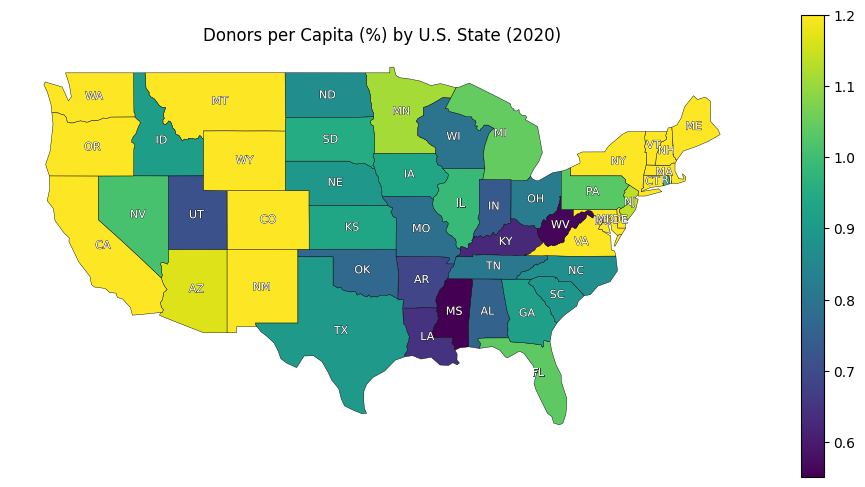

In [57]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=1.2
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Donors per Capita (%) by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

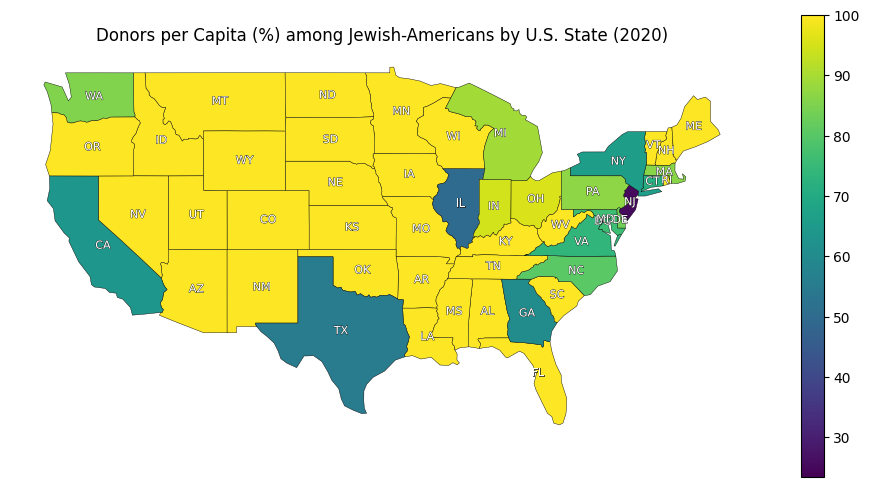

In [58]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_jewish",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=100
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Donors per Capita (%) among Jewish-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

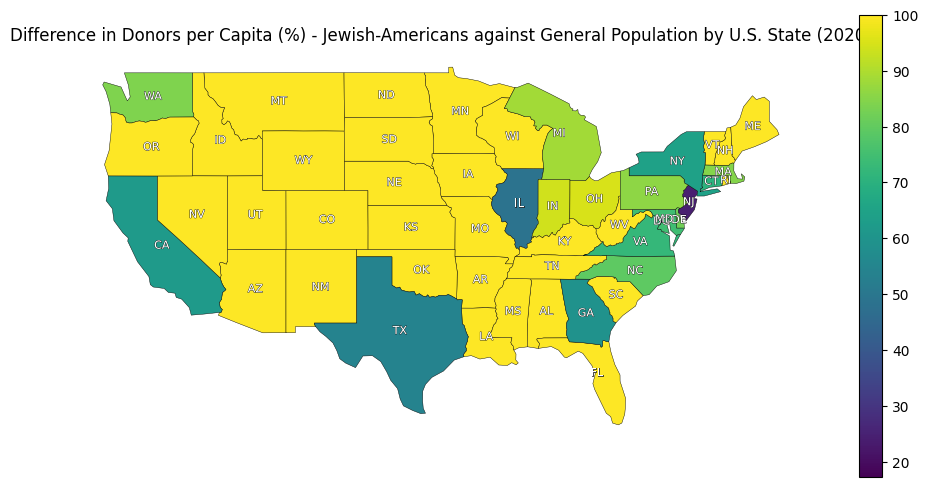

In [59]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="don_per_capita_diff",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=100
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in Donors per Capita (%) - Jewish-Americans against General Population by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

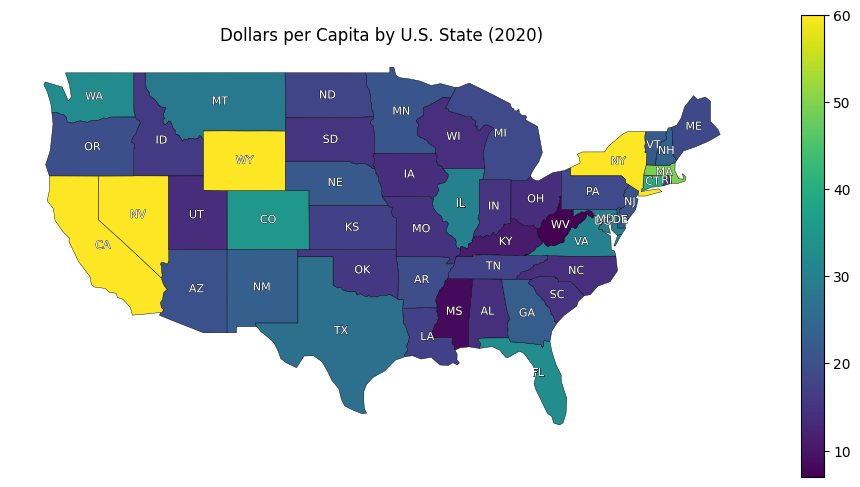

In [60]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmax=60
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars per Capita by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

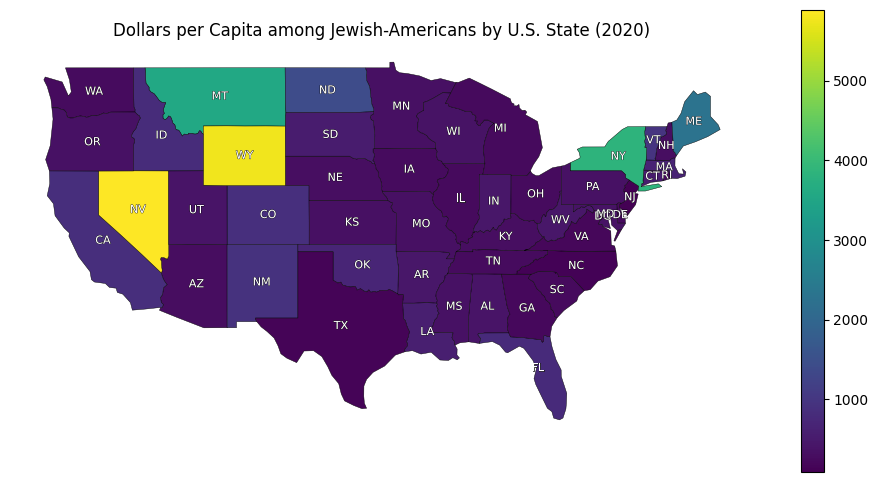

In [61]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_jewish",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"}
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Dollars per Capita among Jewish-Americans by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()

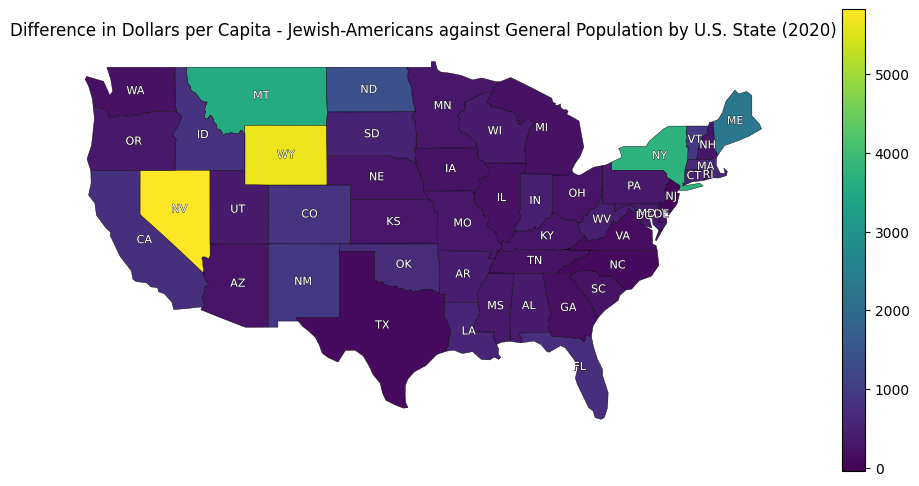

In [62]:
fig, ax = plt.subplots(figsize=(12, 6))
gdf_merged.plot(
    column="dollars_per_capita_diff",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax,
    missing_kwds={"color": "lightgray"},
    vmin=-50
)

cbar = fig.axes[-1]

for idx, row in gdf_merged.iterrows():
    centroid = row["geometry"].centroid
    text = ax.text(centroid.x, centroid.y, row["state"], fontsize=8, ha="center", va="center", color="white")
    text.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground="black"), path_effects.Normal()])

plt.title(f"Difference in Dollars per Capita - Jewish-Americans against General Population by U.S. State (20{year})")
plt.grid(True, linestyle="--", alpha=0.7)
ax.axis("off")
plt.show()